In [ ]:
!pip install earthengine-api geemap folium pandas matplotlib scikit-learn
! earthengine authenticate


import ee
import geemap
import ipywidgets as widgets
from IPython.display import display, clear_output

# Initialize Earth Engine
ee.Initialize()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.9 MB/s eta 0:00:00
E0000 00:00:1751045038.206705     351 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751045038.218578     351 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Authenticate: Limited support in Colab. Use ee.Authenticate() or --auth_mode=notebook instead.
W0627 17:24:02.615210 135928120160256 _default.py:711] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapi

Dans ce projet, j'ai réalisé une étude complète de suivi et d'analyse de l'état de santé d'une forêt à partir d'images satellitaires Sentinel-2. L'objectif principal est d'évaluer la dynamique de la végétation, d'identifier les signes de dépérissement ou de stress forestier, et de cartographier les zones de forêt saine et potentiellement affectée grâce à des techniques d'apprentissage automatique.

In [ ]:
# Définir le polygone d'étude
coords = [[-0.38856573043032583,35.88070656019682],
          [-0.36264486251040395,35.879454769552595],
          [-0.35165853438540395,35.897256154070874],
          [-0.3808409684674352,35.897395211632364],
          [-0.38856573043032583,35.88070656019682]]
polygon = ee.Geometry.Polygon([coords])

In [ ]:
# Fonction pour récupérer la collection Sentinel-2 harmonisée
def get_s2_collection(year, roi):
    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterDate(f'{year}-05-01', f'{year}-05-31')
                  .filterBounds(roi)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))
    return collection


J'ai utilisé les images de la mission Sentinel-2, en ciblant le mois de mai (période de fort développement végétatif) pour les années 2017 à 2023. Pour chaque année, j'ai filtré les images afin de réduire l'impact de la couverture nuageuse, puis calculé la médiane pour obtenir une image composite représentative de la période.
À partir des images prétraitées, j'ai calculé plusieurs indices spectraux couramment utilisés pour l'analyse de la végétation et de l'humidité des sols :
NDVI (Normalized Difference Vegetation Index) : mesure la vigueur de la végétation verte.
SAVI (Soil Adjusted Vegetation Index) : corrige l'effet du sol nu, plus robuste dans les zones peu végétalisées.
NDWI (Normalized Difference Water Index) : lié à l'humidité de la végétation et des sols.
EVI (Enhanced Vegetation Index) : indice complémentaire au NDVI, moins sensible à la saturation dans les zones très denses.
Ces indices ont été calculés pour chaque année et pour la zone d'étude.


Traitement NDVI 2017
Traitement NDVI 2018
Traitement NDVI 2019
Traitement NDVI 2020
Traitement NDVI 2021
Traitement NDVI 2022
Traitement NDVI 2023


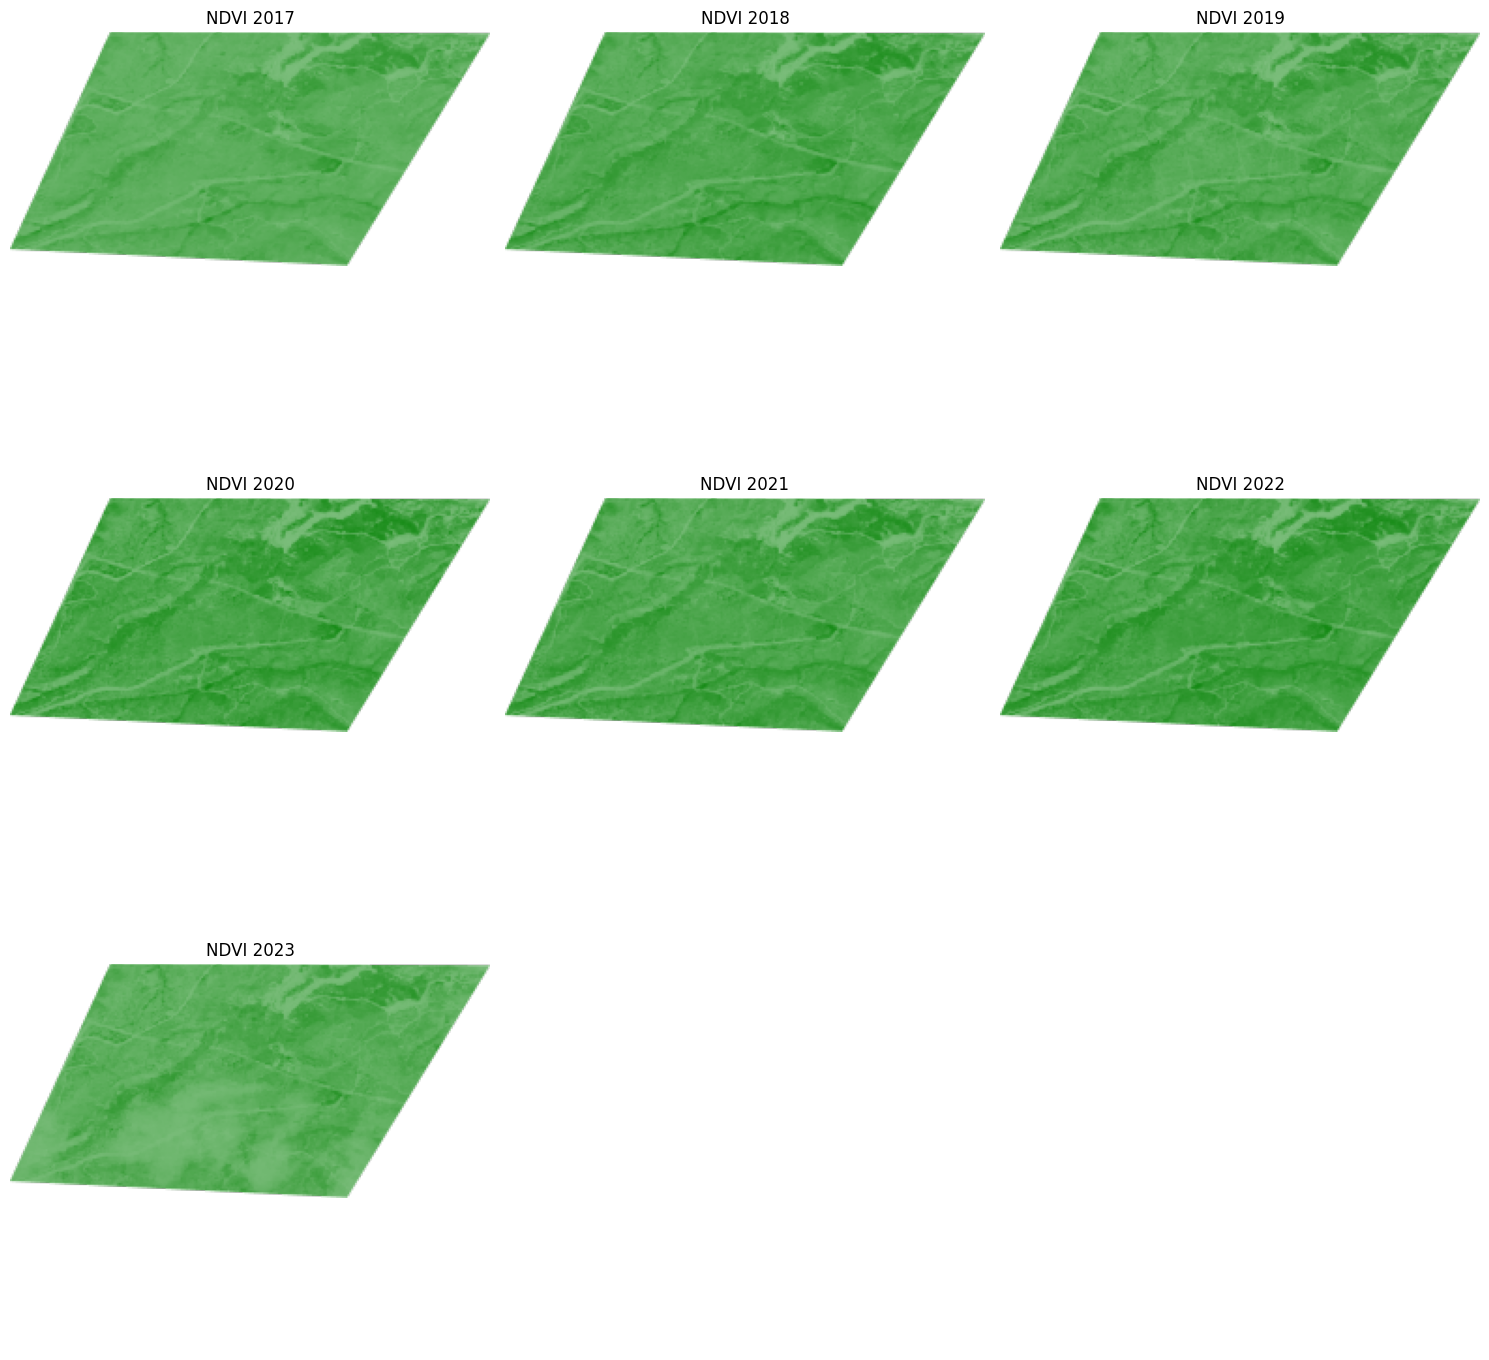

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
#Fonction de calcul NDVI
def calculate_ndvi(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
  return ndvi
#Paramètres de visualisation
ndvi_vis = { 'min': -1, 'max': 1, 'palette': ['white', 'green'] }
years = list(range(2017, 2024))
images_ndvi = []
thumb_size = 256
for year in years:
  print(f"Traitement NDVI {year}")
  collection = get_s2_collection(year, polygon)
  if collection.size().getInfo() == 0:
    print(f"Aucune image disponible pour {year}")
  else:
    image = collection.median().clip(polygon)
    ndvi = calculate_ndvi(image)
    url = ndvi.getThumbURL({
        'min': ndvi_vis['min'],
        'max': ndvi_vis['max'],
        'palette': ndvi_vis['palette'],
        'region': polygon,
        'dimensions': thumb_size
        })
    response = requests.get(url)
    if response.status_code == 200:
      img = Image.open(BytesIO(response.content))
      images_ndvi.append((year, img))
n = len(images_ndvi)
cols = 3
rows = (n // cols) + 1
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axs = axs.flatten()
for i, (year, img) in enumerate(images_ndvi):
  axs[i].imshow(img)
  axs[i].set_title(f'NDVI {year}')
  axs[i].axis('off')
for j in range(n, len(axs)):
  axs[j].axis('off')
plt.tight_layout()
plt.show()

Traitement SAVI 2017
Traitement SAVI 2018
Traitement SAVI 2019
Traitement SAVI 2020
Traitement SAVI 2021
Traitement SAVI 2022
Traitement SAVI 2023


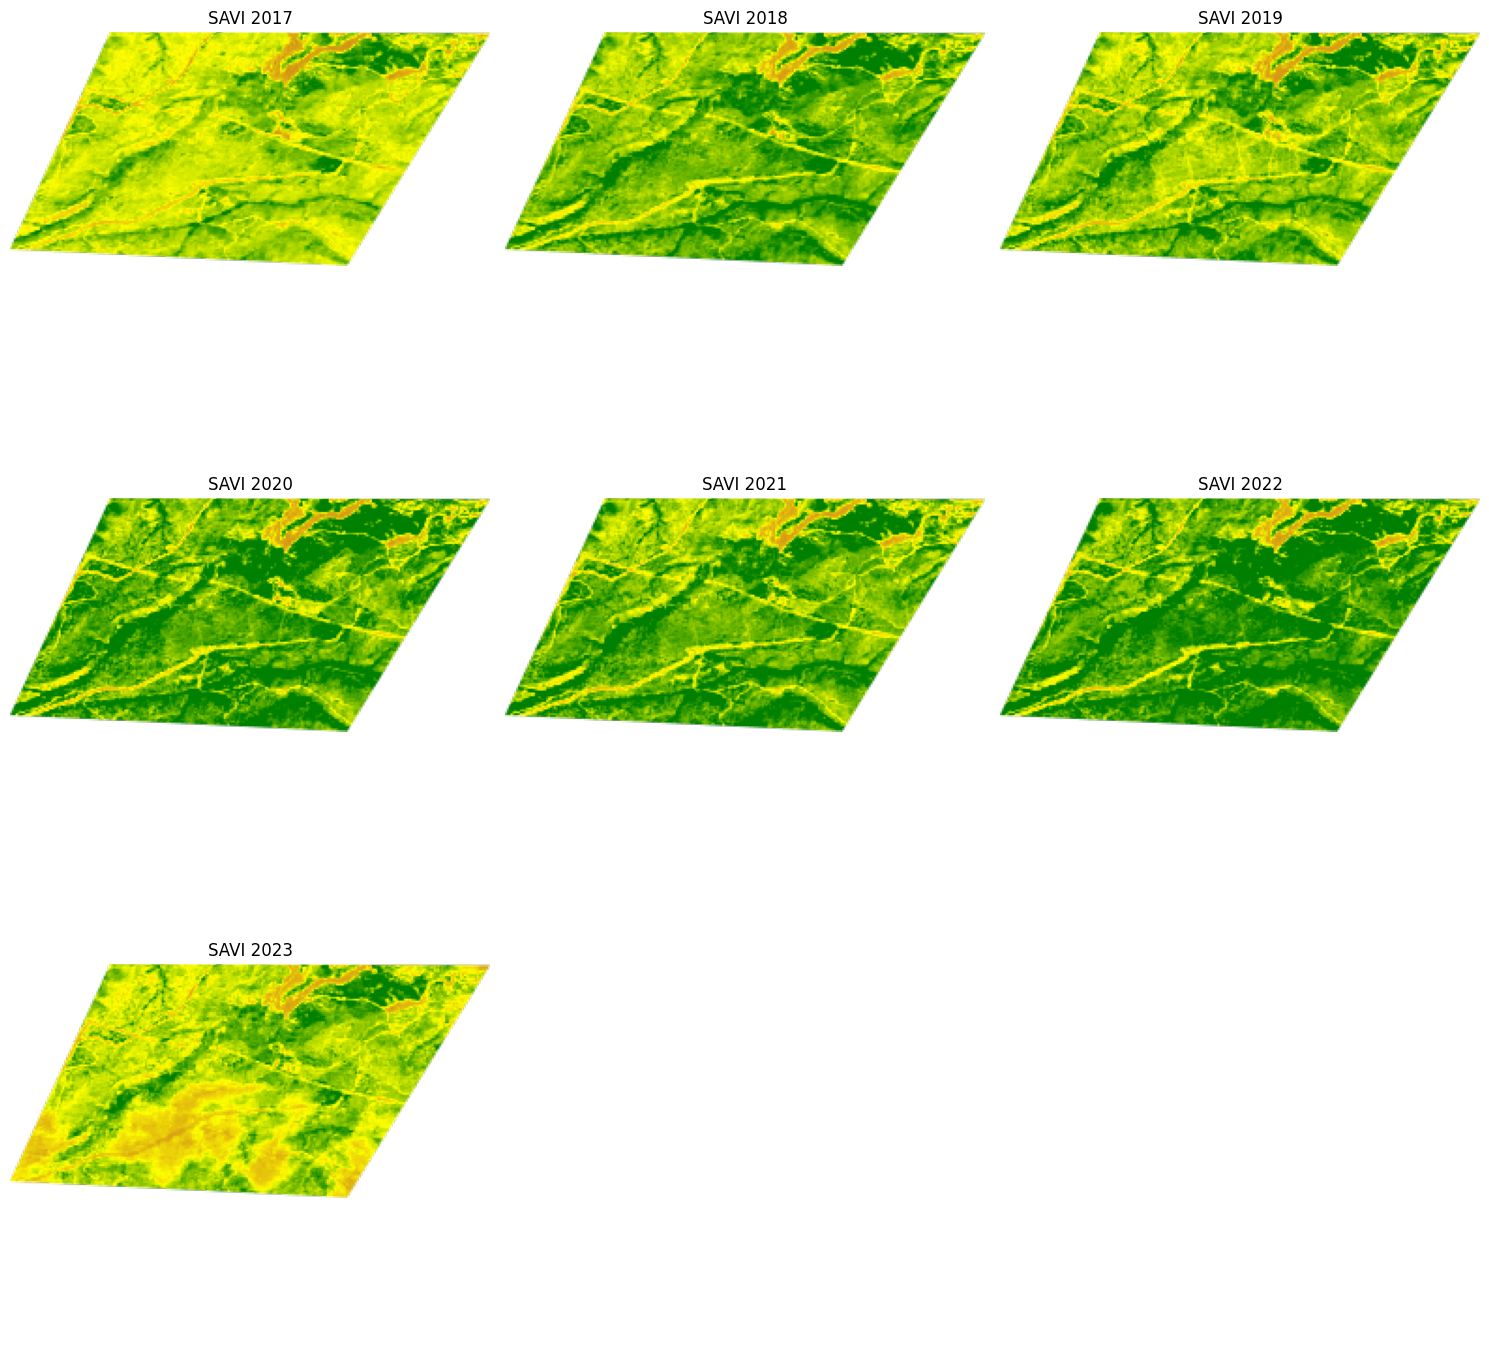

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
#Fonction de calcul SAVI
def calculate_savi(image):
  savi = image.expression( '((NIR - RED) / (NIR + RED + L)) * (1 + L)', { 'NIR': image.select('B8'), 'RED': image.select('B4'), 'L': 0.5 }).rename('SAVI')
  return savi
#Paramètres de visualisation
savi_vis = { 'min': -0.2, 'max': 0.8, 'palette': ['brown', 'yellow', 'green'] }
years = list(range(2017, 2024))
images_savi = []
thumb_size = 256
for year in years:
  print(f"Traitement SAVI {year}")
  collection = get_s2_collection(year, polygon)
  if collection.size().getInfo() == 0:
    print(f"Aucune image disponible pour {year}")
  else:
      image = collection.median().clip(polygon)
      savi = calculate_savi(image)
      url = savi.getThumbURL({
          'min': savi_vis['min'],
          'max': savi_vis['max'],
          'palette': savi_vis['palette'],
          'region': polygon, 'dimensions': thumb_size
          })
      response = requests.get(url)
      if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        images_savi.append((year, img))
n = len(images_savi)
cols = 3
rows = (n // cols) + 1
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axs = axs.flatten()
for i, (year, img) in enumerate(images_savi):
  axs[i].imshow(img)
  axs[i].set_title(f'SAVI {year}')
  axs[i].axis('off')
for j in range(n, len(axs)):
  axs[j].axis('off')
plt.tight_layout()
plt.show()

Traitement NDWI pour 2017
Traitement NDWI pour 2018
Traitement NDWI pour 2019
Traitement NDWI pour 2020
Traitement NDWI pour 2021
Traitement NDWI pour 2022
Traitement NDWI pour 2023


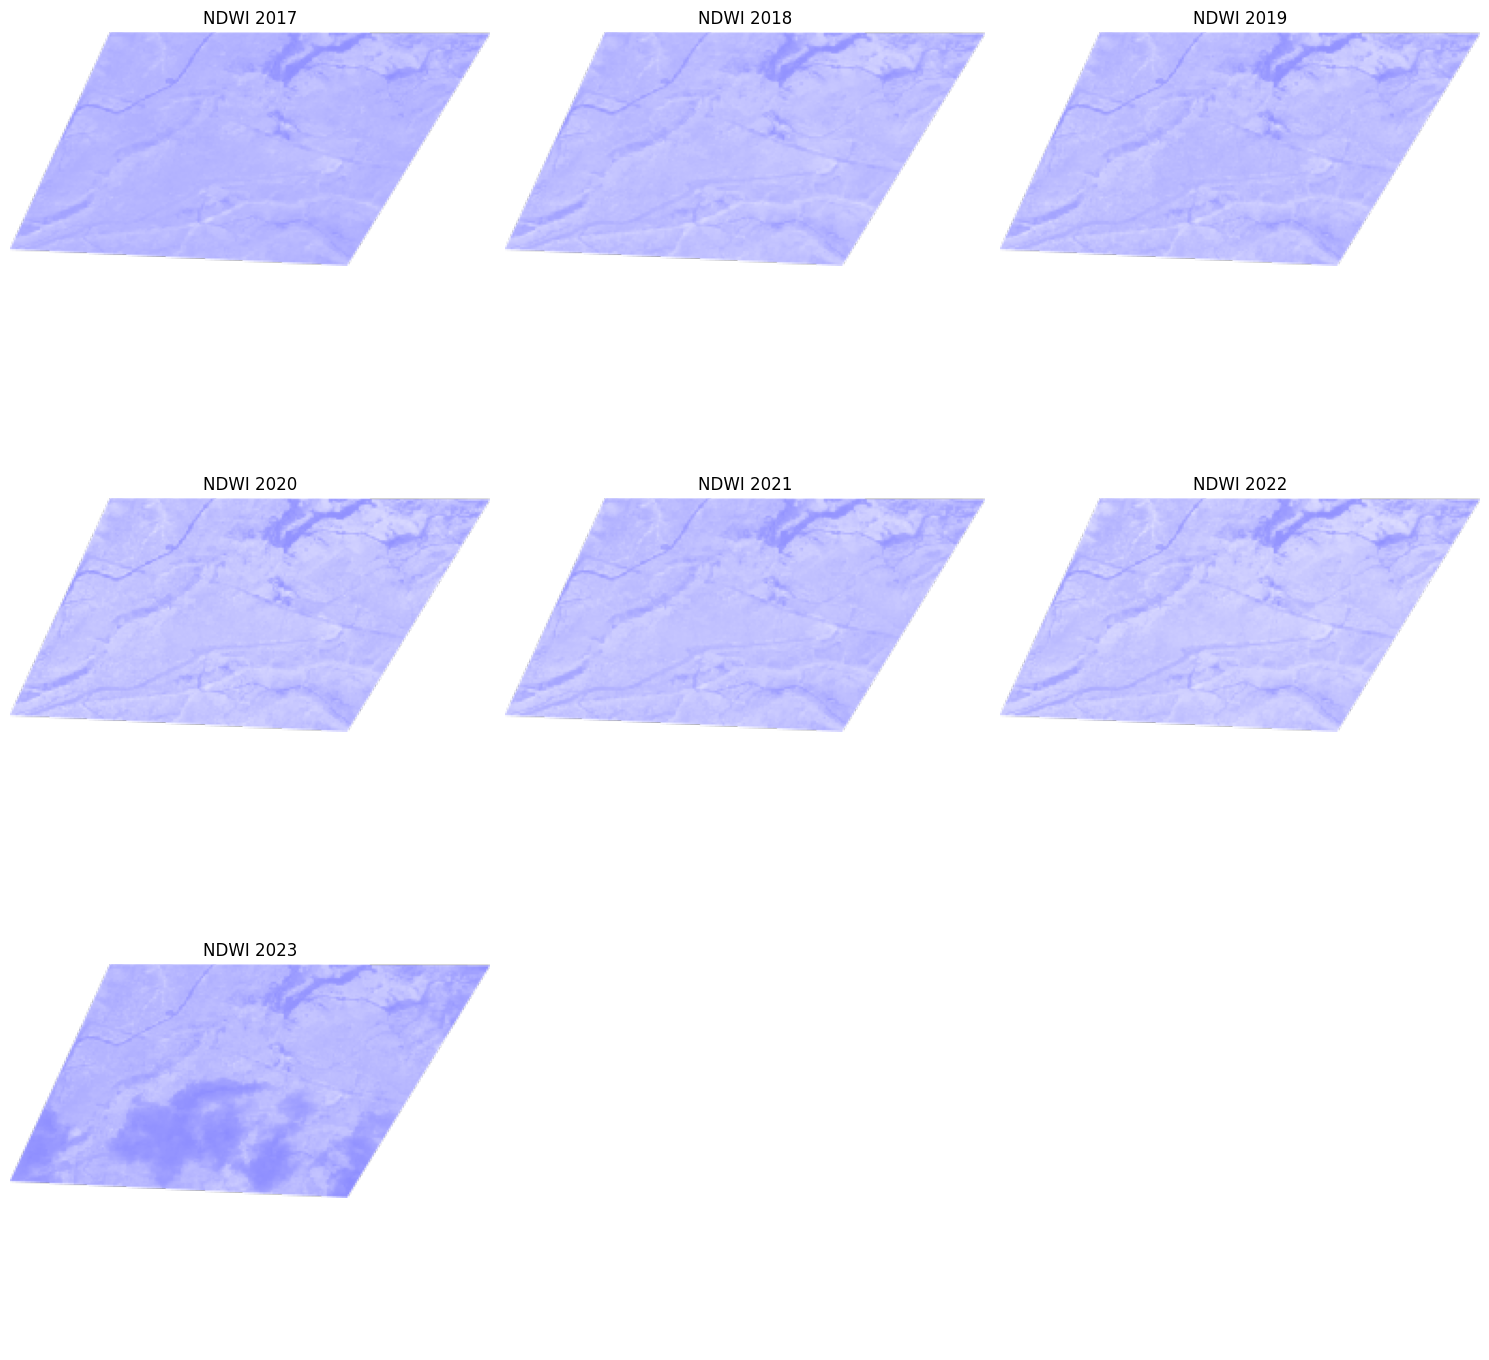

In [ ]:
# Fonction de calcul du NDWI : (Green - NIR) / (Green + NIR)
def calculate_ndwi(image):
    return image.normalizedDifference(['B3', 'B8']).rename('NDWI')

# Paramètres d'affichage pour NDWI
ndwi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['white', 'blue']
}

# Liste des années à traiter
years = list(range(2017, 2024))
images_ndwi = []
thumb_size = 256

# Boucle sur les années pour calculer NDWI
for year in years:
    print(f"Traitement NDWI pour {year}")
    collection = get_s2_collection(year, polygon)

    if collection.size().getInfo() == 0:
        print(f"Aucune image pour {year}")
        continue

    image = collection.median().clip(polygon)
    ndwi = calculate_ndwi(image)

    # Générer l'URL de l'image NDWI
    url = ndwi.getThumbURL({
        'min': ndwi_vis['min'],
        'max': ndwi_vis['max'],
        'palette': ndwi_vis['palette'],
        'region': polygon,
        'dimensions': thumb_size
    })

    # Charger l’image
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    images_ndwi.append((year, img))

# Affichage des NDWI par année avec matplotlib
n = len(images_ndwi)
cols = 3
rows = (n // cols) + 1

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axs = axs.flatten()

for i, (year, img) in enumerate(images_ndwi):
    axs[i].imshow(img)
    axs[i].set_title(f'NDWI {year}')
    axs[i].axis('off')

# Masquer les cases vides
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

Traitement EVI 2017
Traitement EVI 2018
Traitement EVI 2019
Traitement EVI 2020
Traitement EVI 2021
Traitement EVI 2022
Traitement EVI 2023


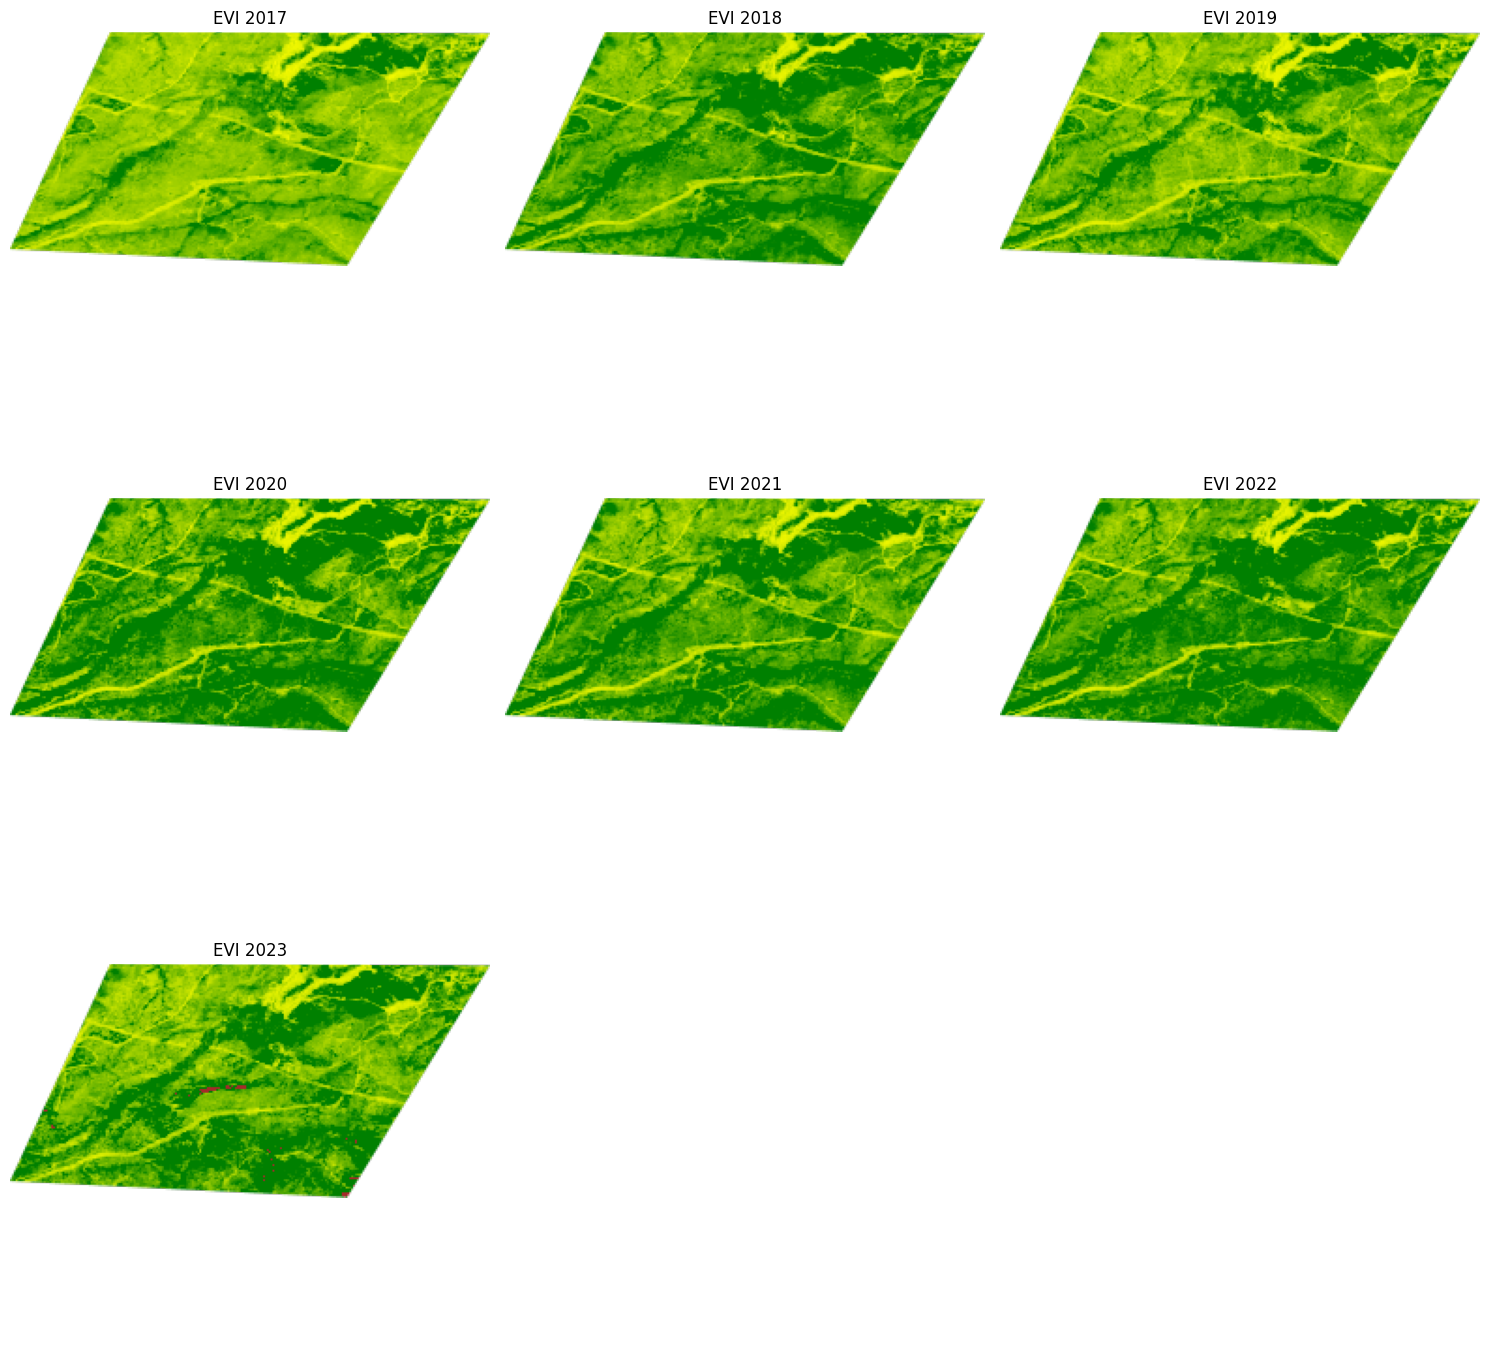

In [ ]:
# Fonction de calcul de l’EVI
def calculate_evi(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('EVI')
    return evi

# Paramètres de visualisation pour EVI
evi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['brown', 'yellow', 'green']
}

# Liste des années
years = list(range(2017, 2024))
images_evi = []
thumb_size = 256

# Boucle de traitement
for year in years:
    print(f"Traitement EVI {year}")
    collection = get_s2_collection(year, polygon)

    if collection.size().getInfo() == 0:
        print(f"Aucune image disponible pour {year}")
        continue

    image = collection.median().clip(polygon)
    evi = calculate_evi(image)

    # Générer l’image à afficher
    url = evi.getThumbURL({
        'min': evi_vis['min'],
        'max': evi_vis['max'],
        'palette': evi_vis['palette'],
        'region': polygon,
        'dimensions': thumb_size
    })

    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    images_evi.append((year, img))

# Affichage subplot
n = len(images_evi)
cols = 3
rows = (n // cols) + 1

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axs = axs.flatten()

for i, (year, img) in enumerate(images_evi):
    axs[i].imshow(img)
    axs[i].set_title(f'EVI {year}')
    axs[i].axis('off')

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

Pour chaque indice, j'ai extrait la valeur moyenne annuelle sur la zone d'étude et produit des graphiques montrant leur évolution de 2017 à 2023. Cela permet de visualiser les tendances globales, comme une éventuelle diminution de la vigueur de la végétation ou des changements d'humidité.

Traitement NDVI pour 2017...
Traitement NDVI pour 2018...
Traitement NDVI pour 2019...
Traitement NDVI pour 2020...
Traitement NDVI pour 2021...
Traitement NDVI pour 2022...
Traitement NDVI pour 2023...
Taille collection pour 2023 : 4


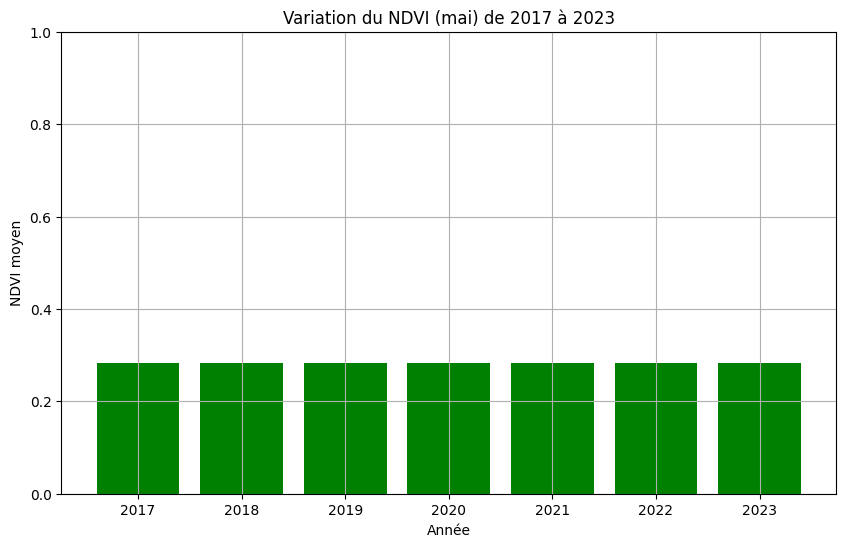

In [ ]:
import ee
import matplotlib.pyplot as plt
#Fonction de calcul du NDVI
def calculate_ndvi(image):
  return image.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_means = []
years = list(range(2017, 2024))
for year in years:
  print(f'Traitement NDVI pour {year}...')
  collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
  collection = collection.filterDate(f'{year}-05-01', f'{year}-05-31')
  collection = collection.filterBounds(polygon)
  collection = collection.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
size = collection.size().getInfo()
print(f"Taille collection pour {year} : {size}")
if size == 0:
  ndvi_means.append(None)
  print("Aucune image disponible.")
else:
    image = collection.median().clip(polygon)
    ndvi = calculate_ndvi(image)
    mean_dict = ndvi.reduceRegion( reducer=ee.Reducer.mean(),
                                  geometry=polygon,
                                  scale=10,
                                   maxPixels=1e9 )
    mean_ndvi = mean_dict.get('NDVI').getInfo()
    ndvi_means.append(mean_ndvi)
plt.figure(figsize=(10, 6))
plt.bar(years, [v if v is not None else 0 for v in ndvi_means], color='green')
plt.xlabel('Année')
plt.ylabel('NDVI moyen')
plt.title('Variation du NDVI (mai) de 2017 à 2023')
plt.grid(True)
plt.ylim(0, 1)
plt.show()

Traitement SAVI pour 2017...
Traitement SAVI pour 2018...
Traitement SAVI pour 2019...
Traitement SAVI pour 2020...
Traitement SAVI pour 2021...
Traitement SAVI pour 2022...
Traitement SAVI pour 2023...


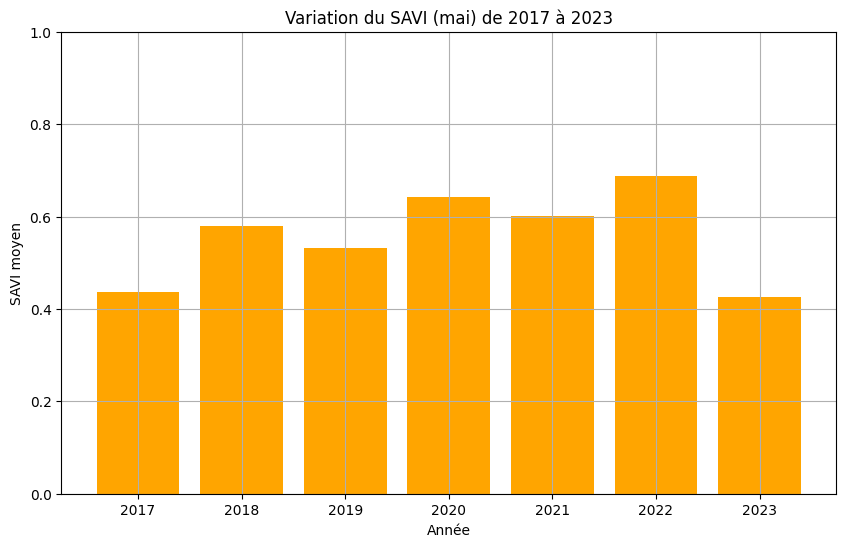

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt

# Authentification Earth Engine
ee.Authenticate()
ee.Initialize()

# Définir le polygone (zone d’étude)
coords = [[-0.38856573043032583, 35.88070656019682],
          [-0.36264486251040395, 35.879454769552595],
          [-0.35165853438540395, 35.897256154070874],
          [-0.3808409684674352, 35.897395211632364],
          [-0.38856573043032583, 35.88070656019682]]
polygon = ee.Geometry.Polygon([coords])

# Liste des années
years = list(range(2017, 2024))
savi_means = []

# Fonction de calcul du SAVI (L = 0.5)
def calculate_savi(image):
    savi = image.expression(
        '((NIR - RED) / (NIR + RED + L)) * (1 + L)', {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'L': 0.5
        }).rename('SAVI')
    return savi

# Boucle annuelle
for year in years:
    print(f'Traitement SAVI pour {year}...')
    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterDate(f'{year}-05-01', f'{year}-05-31')
                  .filterBounds(polygon)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

    if collection.size().getInfo() == 0:
        savi_means.append(None)
        print("Aucune image disponible.")
        continue

    image = collection.median().clip(polygon)
    savi = calculate_savi(image)

    mean_dict = savi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=polygon,
        scale=10,
        maxPixels=1e9
    )
    mean_savi = mean_dict.get('SAVI').getInfo()
    savi_means.append(mean_savi)

# Affichage du graphique
plt.figure(figsize=(10, 6))
plt.bar(years, savi_means, color='orange')
plt.xlabel('Année')
plt.ylabel('SAVI moyen')
plt.title('Variation du SAVI (mai) de 2017 à 2023')
plt.grid(True)
plt.ylim(0, 1)
plt.show()



Traitement NDWI pour 2017...
Traitement NDWI pour 2018...
Traitement NDWI pour 2019...
Traitement NDWI pour 2020...
Traitement NDWI pour 2021...
Traitement NDWI pour 2022...
Traitement NDWI pour 2023...


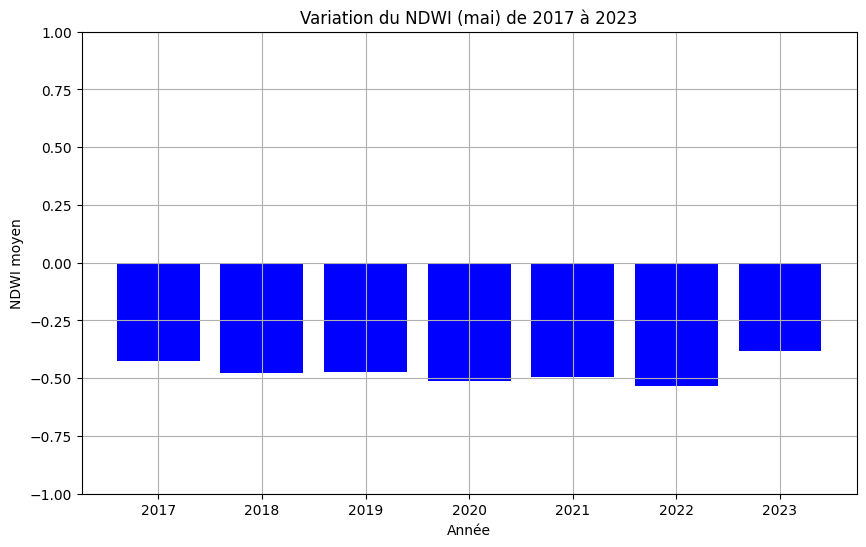

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt

# Authentification Earth Engine
ee.Authenticate()
ee.Initialize()

# Définir la zone d’étude (polygone)
coords = [[-0.38856573043032583, 35.88070656019682],
          [-0.36264486251040395, 35.879454769552595],
          [-0.35165853438540395, 35.897256154070874],
          [-0.3808409684674352, 35.897395211632364],
          [-0.38856573043032583, 35.88070656019682]]
polygon = ee.Geometry.Polygon([coords])

# Liste des années à traiter
years = list(range(2017, 2024))
ndwi_means = []

# Fonction de calcul du NDWI
def calculate_ndwi(image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return ndwi

# Traitement par année
for year in years:
    print(f'Traitement NDWI pour {year}...')
    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterDate(f'{year}-05-01', f'{year}-05-31')
                  .filterBounds(polygon)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

    if collection.size().getInfo() == 0:
        ndwi_means.append(None)
        print("Aucune image disponible.")
        continue

    image = collection.median().clip(polygon)
    ndwi = calculate_ndwi(image)

    mean_dict = ndwi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=polygon,
        scale=10,
        maxPixels=1e9
    )
    mean_ndwi = mean_dict.get('NDWI').getInfo()
    ndwi_means.append(mean_ndwi)

# Affichage du graphique
plt.figure(figsize=(10, 6))
plt.bar(years, ndwi_means, color='blue')
plt.xlabel('Année')
plt.ylabel('NDWI moyen')
plt.title('Variation du NDWI (mai) de 2017 à 2023')
plt.grid(True)
plt.ylim(-1, 1)
plt.show()


Traitement EVI pour 2017...
Traitement EVI pour 2018...
Traitement EVI pour 2019...
Traitement EVI pour 2020...
Traitement EVI pour 2021...
Traitement EVI pour 2022...
Traitement EVI pour 2023...


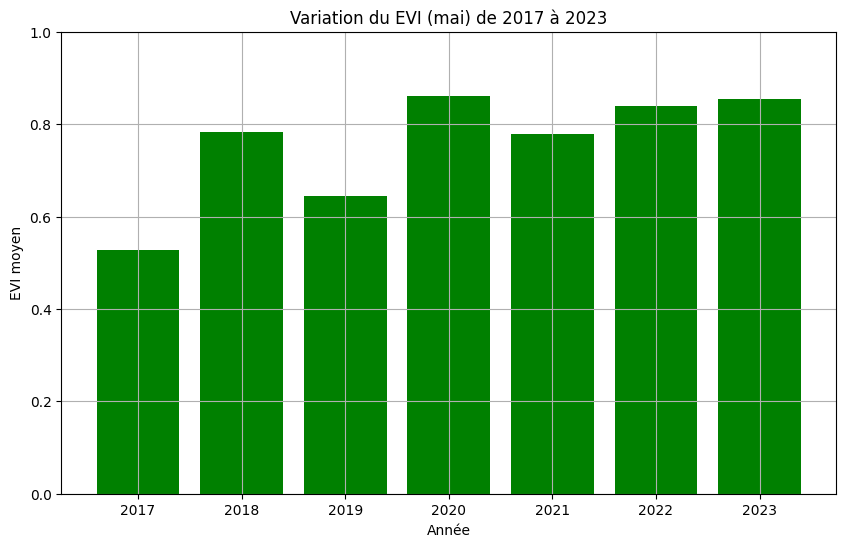

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt

# Authentification à Earth Engine
ee.Authenticate()
ee.Initialize()

# Définir la zone d’étude (polygone)
coords = [[-0.38856573043032583, 35.88070656019682],
          [-0.36264486251040395, 35.879454769552595],
          [-0.35165853438540395, 35.897256154070874],
          [-0.3808409684674352, 35.897395211632364],
          [-0.38856573043032583, 35.88070656019682]]
polygon = ee.Geometry.Polygon([coords])

# Années à analyser
years = list(range(2017, 2024))
evi_means = []

# Fonction pour calculer l’EVI
def calculate_evi(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1))', {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('EVI')
    return evi

# Boucle de traitement annuel
for year in years:
    print(f'Traitement EVI pour {year}...')
    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterDate(f'{year}-05-01', f'{year}-05-31')
                  .filterBounds(polygon)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

    if collection.size().getInfo() == 0:
        evi_means.append(None)
        print("Aucune image disponible.")
        continue

    image = collection.median().clip(polygon)
    evi = calculate_evi(image)

    mean_dict = evi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=polygon,
        scale=10,
        maxPixels=1e9
    )
    mean_evi = mean_dict.get('EVI').getInfo()
    evi_means.append(mean_evi)

# Affichage du graphique
plt.figure(figsize=(10, 6))
plt.bar(years, evi_means, color='green')
plt.xlabel('Année')
plt.ylabel('EVI moyen')
plt.title('Variation du EVI (mai) de 2017 à 2023')
plt.grid(True)
plt.ylim(0, 1)
plt.show()


In [ ]:
import ee
import geemap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Authentification Earth Engine
ee.Authenticate()
ee.Initialize()

# Définir ta zone d’étude
coords = [[-0.38856573043032583, 35.88070656019682],
          [-0.36264486251040395, 35.879454769552595],
          [-0.35165853438540395, 35.897256154070874],
          [-0.3808409684674352, 35.897395211632364],
          [-0.38856573043032583, 35.88070656019682]]
polygon = ee.Geometry.Polygon([coords])

# Fonction pour calculer NDVI et SAVI
def add_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    savi = image.expression(
        '((NIR - RED) / (NIR + RED + L)) * (1 + L)', {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'L': 0.5
        }).rename('SAVI')
    return image.addBands([ndvi, savi])

In [ ]:
# Récupérer la collection Sentinel-2
collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterDate('2017-01-01', '2023-12-31')
              .filterBounds(polygon)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
              .map(add_indices))

# Réduire tous les pixels dans la région d’intérêt à une liste
def extract_values(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=polygon,
        scale=10,
        maxPixels=1e9
    )
    return ee.Feature(None, stats).set('system:time_start', image.date().millis())

# Appliquer la fonction à toute la collection
features = collection.map(extract_values)

# Convertir en DataFrame
fc = features.getInfo()
data = []
for f in fc['features']:
    props = f['properties']
    timestamp = props.get('system:time_start')
    if timestamp is not None and props.get('NDVI') is not None and props.get('SAVI') is not None:
        data.append({
            'NDVI': props['NDVI'],
            'SAVI': props['SAVI']
        })

df = pd.DataFrame(data)

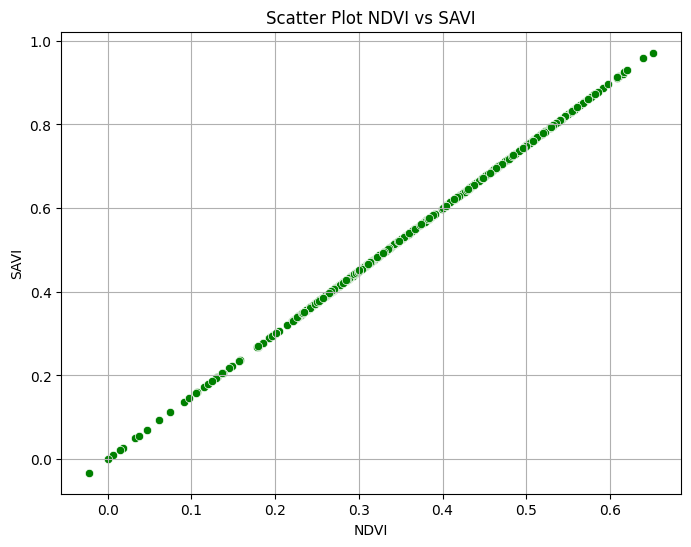

In [ ]:
# ✅ SCATTER PLOT NDVI vs SAVI
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='NDVI', y='SAVI', color='green')
plt.title("Scatter Plot NDVI vs SAVI")
plt.xlabel("NDVI")
plt.ylabel("SAVI")
plt.grid(True)
plt.show()

J'ai réalisé une matrice de corrélation entre les différents indices (par ex. NDVI et NDWI) pour étudier leurs relations et vérifier la cohérence des résultats. Cette étape est importante pour interpréter les interactions entre variables et valider les choix d'indices pour la suite.

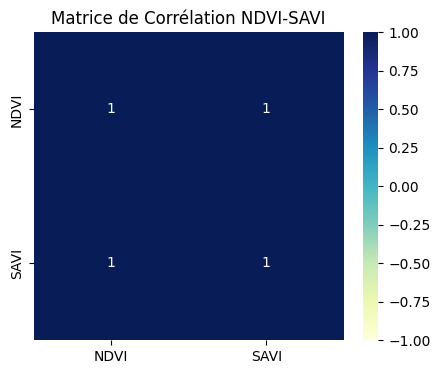

In [ ]:
# ✅ MATRICE DE CORRÉLATION
corr = df.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='YlGnBu', vmin=-1, vmax=1)
plt.title("Matrice de Corrélation NDVI-SAVI")
plt.show()


In [ ]:
import ee
import geemap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Authentification et initialisation
ee.Authenticate()
ee.Initialize()

# Zone d’étude (rectangle défini par tes coordonnées)
coords = [[-0.38856573043032583, 35.88070656019682],
          [-0.36264486251040395, 35.879454769552595],
          [-0.35165853438540395, 35.897256154070874],
          [-0.3808409684674352, 35.897395211632364],
          [-0.38856573043032583, 35.88070656019682]]
polygon = ee.Geometry.Polygon([coords])

# Fonction pour ajouter NDVI et NDWI
def add_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands([ndvi, ndwi])

# Charger la collection Sentinel-2 filtrée sur la zone et les dates
collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterDate('2017-01-01', '2023-12-31')
              .filterBounds(polygon)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
              .map(add_indices))

# Fonction pour extraire les valeurs moyennes par image
def extract_values(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=polygon,
        scale=10,
        maxPixels=1e9
    )
    return ee.Feature(None, stats).set('system:time_start', image.date().millis())

# Appliquer sur toute la collection
features = collection.map(extract_values)

# Récupérer les données sous forme de DataFrame
fc = features.getInfo()
data = []
for f in fc['features']:
    props = f['properties']
    if props.get('NDVI') is not None and props.get('NDWI') is not None:
        data.append({
            'NDVI': props['NDVI'],
            'NDWI': props['NDWI']
        })

df = pd.DataFrame(data)


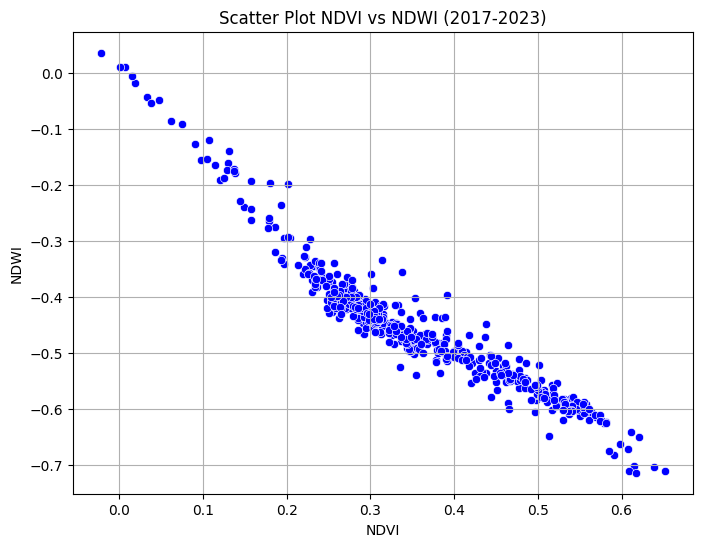

In [ ]:
# ✅ SCATTER PLOT : NDVI vs NDWI
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='NDVI', y='NDWI', color='blue')
plt.title("Scatter Plot NDVI vs NDWI (2017-2023)")
plt.xlabel("NDVI")
plt.ylabel("NDWI")
plt.grid(True)
plt.show()

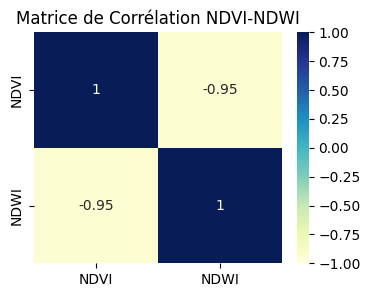

In [ ]:
#MATRICE DE CORRÉLATION ENTRE NDVI ET NDWI
corr = df[['NDVI', 'NDWI']].corr()
plt.figure(figsize=(4, 3))
sns.heatmap(corr, annot=True, cmap='YlGnBu', vmin=-1, vmax=1)
plt.title("Matrice de Corrélation NDVI-NDWI")
plt.show()

<Figure size 600x600 with 0 Axes>

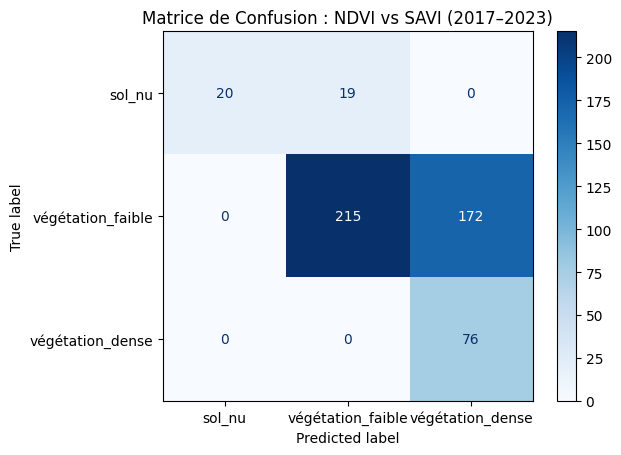

In [ ]:
import ee
import geemap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Authentification
ee.Authenticate()
ee.Initialize()

# Définir la zone d’intérêt
coords = [[-0.38856573043032583, 35.88070656019682],
          [-0.36264486251040395, 35.879454769552595],
          [-0.35165853438540395, 35.897256154070874],
          [-0.3808409684674352, 35.897395211632364],
          [-0.38856573043032583, 35.88070656019682]]
polygon = ee.Geometry.Polygon([coords])

# Ajouter NDVI, SAVI, NDWI, EVI
def add_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    savi = image.expression('((NIR - RED) / (NIR + RED + L)) * (1 + L)', {
        'NIR': image.select('B8'),
        'RED': image.select('B4'),
        'L': 0.5
    }).rename('SAVI')
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('EVI')
    return image.addBands([ndvi, savi, ndwi, evi])

# Charger images
collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterDate('2017-01-01', '2023-12-31')
              .filterBounds(polygon)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
              .map(add_indices))

# Extraire les moyennes
def extract_values(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=polygon,
        scale=10,
        maxPixels=1e9
    )
    return ee.Feature(None, stats).set('system:time_start', image.date().millis())

features = collection.map(extract_values)

# Convertir en DataFrame
fc = features.getInfo()
data = []
for f in fc['features']:
    p = f['properties']
    if all(k in p for k in ['NDVI', 'SAVI', 'NDWI', 'EVI']):
        data.append({
            'NDVI': p['NDVI'],
            'SAVI': p['SAVI'],
            'NDWI': p['NDWI'],
            'EVI': p['EVI']
        })

df = pd.DataFrame(data)

# Catégoriser NDVI et SAVI
def classify_index(value):
    if value < 0.2:
        return 'sol_nu'
    elif value < 0.5:
        return 'végétation_faible'
    else:
        return 'végétation_dense'

df['NDVI_class'] = df['NDVI'].apply(classify_index)
df['SAVI_class'] = df['SAVI'].apply(classify_index)

# Matrice de confusion NDVI vs SAVI
cm = confusion_matrix(df['NDVI_class'], df['SAVI_class'], labels=['sol_nu', 'végétation_faible', 'végétation_dense'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['sol_nu', 'végétation_faible', 'végétation_dense'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues')
plt.title('Matrice de Confusion : NDVI vs SAVI (2017–2023)')
plt.show()

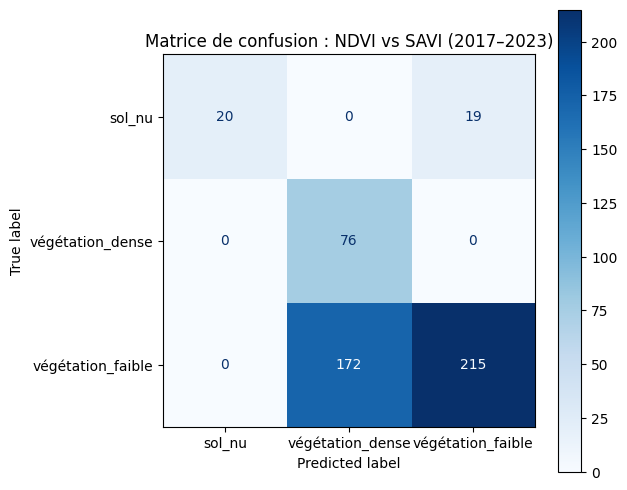

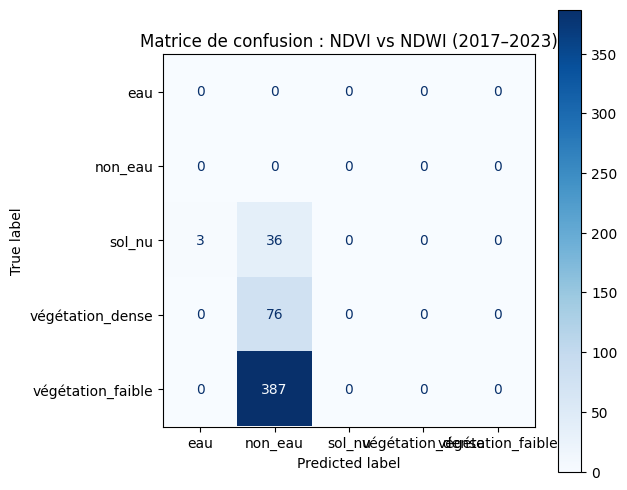

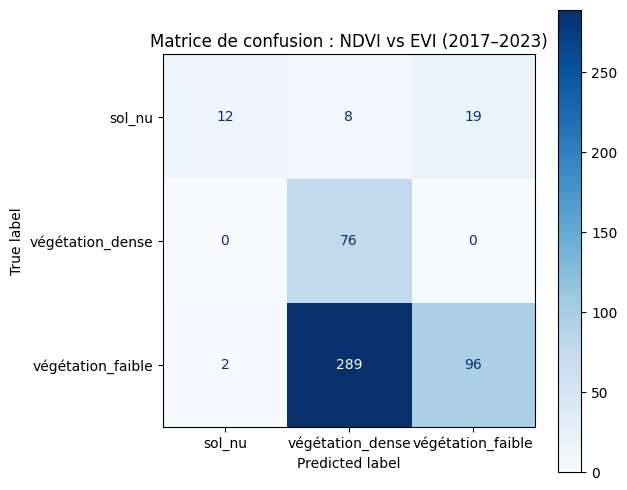

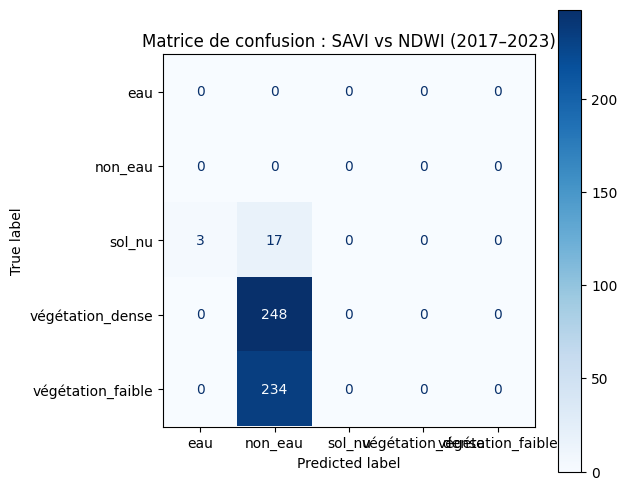

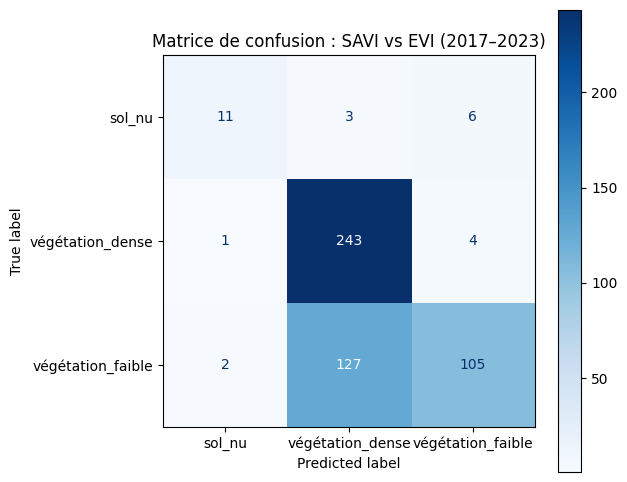

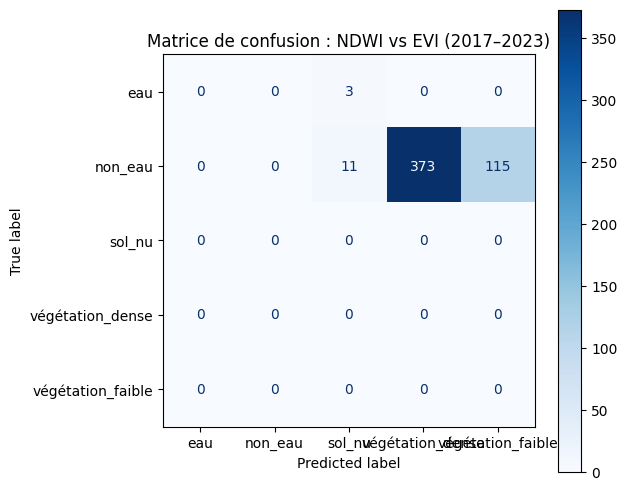

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Authentification et initialisation Earth Engine
ee.Authenticate()
ee.Initialize()

# Définir la zone polygonale (coords fournies)
coords = [[-0.38856573043032583, 35.88070656019682],
          [-0.36264486251040395, 35.879454769552595],
          [-0.35165853438540395, 35.897256154070874],
          [-0.3808409684674352, 35.897395211632364],
          [-0.38856573043032583, 35.88070656019682]]
polygon = ee.Geometry.Polygon([coords])

# Fonction pour ajouter NDVI, SAVI, NDWI, EVI à une image Sentinel-2
def add_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    savi = image.expression('((NIR - RED) / (NIR + RED + L)) * (1 + L)', {
        'NIR': image.select('B8'),
        'RED': image.select('B4'),
        'L': 0.5
    }).rename('SAVI')
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('EVI')
    return image.addBands([ndvi, savi, ndwi, evi])

# Charger collection Sentinel-2
collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterDate('2017-01-01', '2023-12-31')
              .filterBounds(polygon)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
              .map(add_indices))

# Extraire valeurs moyennes sur la zone
def extract_values(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=polygon,
        scale=10,
        maxPixels=1e9
    )
    return ee.Feature(None, stats).set('system:time_start', image.date().millis())

features = collection.map(extract_values)

# Convertir en DataFrame
fc = features.getInfo()
data = []
for f in fc['features']:
    p = f['properties']
    if all(k in p for k in ['NDVI', 'SAVI', 'NDWI', 'EVI']):
        data.append({
            'NDVI': p['NDVI'],
            'SAVI': p['SAVI'],
            'NDWI': p['NDWI'],
            'EVI': p['EVI']
        })

df = pd.DataFrame(data)

# Fonction pour classer chaque indice
def classify(value, index_type):
    if index_type in ['NDVI', 'SAVI', 'EVI']:
        if value < 0.2:
            return 'sol_nu'
        elif value < 0.5:
            return 'végétation_faible'
        else:
            return 'végétation_dense'
    elif index_type == 'NDWI':
        return 'eau' if value > 0 else 'non_eau'

# Appliquer classification
for idx in ['NDVI', 'SAVI', 'NDWI', 'EVI']:
    df[f'{idx}_class'] = df[idx].apply(lambda x: classify(x, idx))

# Liste des couples à comparer
pairs = [('NDVI', 'SAVI'), ('NDVI', 'NDWI'), ('NDVI', 'EVI'),
         ('SAVI', 'NDWI'), ('SAVI', 'EVI'), ('NDWI', 'EVI')]

# Afficher matrices de confusion
import matplotlib.pyplot as plt

for (a, b) in pairs:
    y_true = df[f'{a}_class']
    y_pred = df[f'{b}_class']
    labels = sorted(list(set(y_true) | set(y_pred)))

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    plt.figure(figsize=(6, 6))
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title(f'Matrice de confusion : {a} vs {b} (2017–2023)')
    plt.show()



Confusion Matrix:
[[25  0]
 [ 0 35]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        35

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



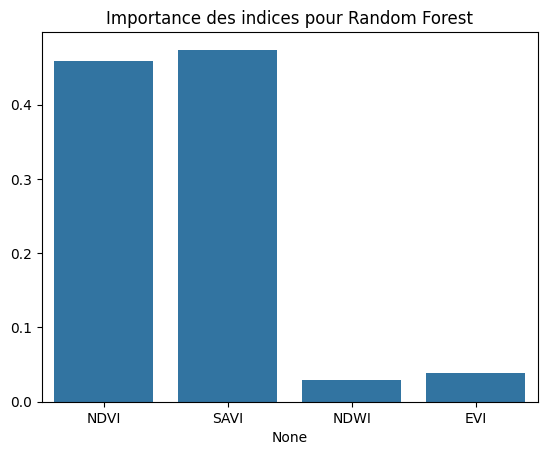

In [ ]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Authentification
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# Définir la zone d'intérêt avec tes coordonnées
geometry = ee.Geometry.Polygon([[
    [-0.38856573043032583, 35.88070656019682],
    [-0.36264486251040395, 35.879454769552595],
    [-0.35165853438540395, 35.897256154070874],
    [-0.3808409684674352, 35.897395211632364],
    [-0.38856573043032583, 35.88070656019682]
]])

# Charger Sentinel-2 (2017-2023)
collection = ee.ImageCollection('COPERNICUS/S2_SR')\
    .filterBounds(geometry)\
    .filterDate('2017-01-01', '2023-12-31')\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

def add_indices(img):
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    savi = img.expression('((NIR - RED) / (NIR + RED + 0.5)) * (1.5)', {
        'NIR': img.select('B8'), 'RED': img.select('B4')
    }).rename('SAVI')
    ndwi = img.normalizedDifference(['B3', 'B8']).rename('NDWI')
    evi = img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': img.select('B8'), 'RED': img.select('B4'), 'BLUE': img.select('B2')
    }).rename('EVI')
    return img.addBands([ndvi, savi, ndwi, evi])

# Ajouter les indices
indexed = collection.map(add_indices)

# Image moyenne (2017-2023)
mean_image = indexed.select(['NDVI', 'SAVI', 'NDWI', 'EVI']).mean().clip(geometry)

# Créer des points d'entraînement fictifs (ex : 0 = sol nu, 1 = végétation)
# Pour un vrai projet : importer un FeatureCollection labelisé
training_points = mean_image.sample(region=geometry, scale=10, numPixels=200, geometries=True).map(
    lambda f: f.set('class', ee.Number(f.get('NDVI')).gt(0.3).int())
)

# Exporter les échantillons (exécuter dans GEE pour vrai export)
# En local : extraire les données en Pandas
features = training_points.getInfo()['features']
data = [{**f['properties']} for f in features]
df = pd.DataFrame(data)

# Entraînement Random Forest
X = df[['NDVI', 'SAVI', 'NDWI', 'EVI']]
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Afficher importance des indices
importances = model.feature_importances_
sns.barplot(x=X.columns, y=importances)
plt.title('Importance des indices pour Random Forest')
plt.show()


Enfin, j'ai utilisé les valeurs d'indices spectraux comme variables d'entrée pour entraîner et appliquer un modèle de classification Random Forest. Ce modèle permet de distinguer les zones de forêt saine et de forêt dépérissante (ou stressée). Les résultats incluent :
Un histogramme montrant la distribution des classes (forêt saine vs malade).
Une carte de classification, permettant de localiser les zones problématiques sur l'image.


Random Forest - Confusion Matrix:
[[25  0]
 [ 0 35]]

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        35

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


SVM - Confusion Matrix:
[[21  4]
 [ 5 30]]

SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        25
           1       0.88      0.86      0.87        35

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



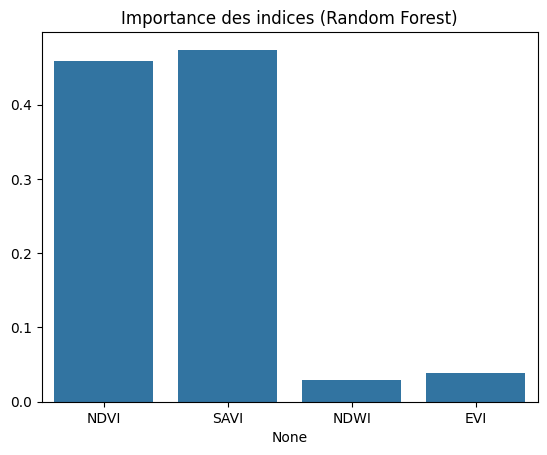

In [ ]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Authentification
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# Définir la zone d'intérêt avec tes coordonnées
geometry = ee.Geometry.Polygon([[
    [-0.38856573043032583, 35.88070656019682],
    [-0.36264486251040395, 35.879454769552595],
    [-0.35165853438540395, 35.897256154070874],
    [-0.3808409684674352, 35.897395211632364],
    [-0.38856573043032583, 35.88070656019682]
]])

# Charger Sentinel-2 (2017-2023)
collection = ee.ImageCollection('COPERNICUS/S2_SR')\
    .filterBounds(geometry)\
    .filterDate('2017-01-01', '2023-12-31')\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

def add_indices(img):
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    savi = img.expression('((NIR - RED) / (NIR + RED + 0.5)) * (1.5)', {
        'NIR': img.select('B8'), 'RED': img.select('B4')
    }).rename('SAVI')
    ndwi = img.normalizedDifference(['B3', 'B8']).rename('NDWI')
    evi = img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': img.select('B8'), 'RED': img.select('B4'), 'BLUE': img.select('B2')
    }).rename('EVI')
    return img.addBands([ndvi, savi, ndwi, evi])

# Ajouter les indices
indexed = collection.map(add_indices)

# Image moyenne (2017-2023)
mean_image = indexed.select(['NDVI', 'SAVI', 'NDWI', 'EVI']).mean().clip(geometry)

# Créer des points d'entraînement fictifs (ex : 0 = sol nu, 1 = végétation)
training_points = mean_image.sample(region=geometry, scale=10, numPixels=200, geometries=True).map(
    lambda f: f.set('class', ee.Number(f.get('NDVI')).gt(0.3).int())
)

# Extraire les données en Pandas
features = training_points.getInfo()['features']
data = [{**f['properties']} for f in features]
df = pd.DataFrame(data)

X = df[['NDVI', 'SAVI', 'NDWI', 'EVI']]
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# SVM
svm_model = SVC(kernel='rbf', gamma='scale', C=1)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Résultats Random Forest
print("\nRandom Forest - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Résultats SVM
print("\nSVM - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nSVM - Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Comparaison des importances (RF seulement)
importances = rf_model.feature_importances_
sns.barplot(x=X.columns, y=importances)
plt.title('Importance des indices (Random Forest)')
plt.show()


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)



Random Forest - Confusion Matrix:
[[25  0]
 [ 0 35]]

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        35

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


SVM - Confusion Matrix:
[[21  4]
 [ 5 30]]

SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        25
           1       0.88      0.86      0.87        35

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



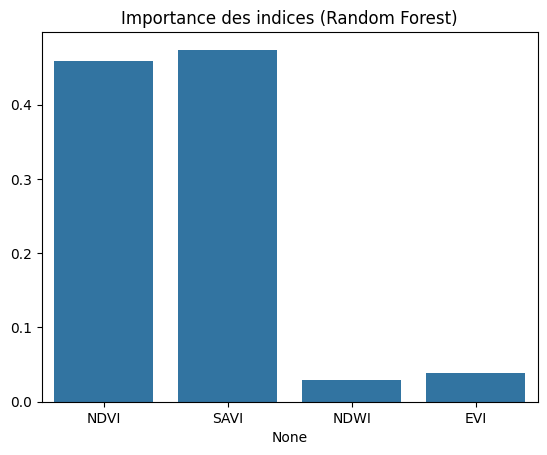

In [ ]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Authentification
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# Définir la zone d'intérêt avec tes coordonnées
geometry = ee.Geometry.Polygon([[
    [-0.38856573043032583, 35.88070656019682],
    [-0.36264486251040395, 35.879454769552595],
    [-0.35165853438540395, 35.897256154070874],
    [-0.3808409684674352, 35.897395211632364],
    [-0.38856573043032583, 35.88070656019682]
]])

# Charger Sentinel-2 (2017-2023)
collection = ee.ImageCollection('COPERNICUS/S2_SR')\
    .filterBounds(geometry)\
    .filterDate('2017-01-01', '2023-12-31')\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

def add_indices(img):
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    savi = img.expression('((NIR - RED) / (NIR + RED + 0.5)) * (1.5)', {
        'NIR': img.select('B8'), 'RED': img.select('B4')
    }).rename('SAVI')
    ndwi = img.normalizedDifference(['B3', 'B8']).rename('NDWI')
    evi = img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': img.select('B8'), 'RED': img.select('B4'), 'BLUE': img.select('B2')
    }).rename('EVI')
    return img.addBands([ndvi, savi, ndwi, evi])

# Ajouter les indices
indexed = collection.map(add_indices)

# Image moyenne (2017-2023)
mean_image = indexed.select(['NDVI', 'SAVI', 'NDWI', 'EVI']).mean().clip(geometry)

# Créer des points d'entraînement fictifs (0 = sol nu, 1 = végétation)
training_points = mean_image.sample(region=geometry, scale=10, numPixels=200, geometries=True).map(
    lambda f: f.set('class', ee.Number(f.get('NDVI')).gt(0.3).int())
)

# Extraire les données en Pandas
features = training_points.getInfo()['features']
data = [{**f['properties']} for f in features]
df = pd.DataFrame(data)

X = df[['NDVI', 'SAVI', 'NDWI', 'EVI']]
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# SVM
svm_model = SVC(kernel='rbf', gamma='scale', C=1)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Résultats Random Forest
print("\nRandom Forest - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Résultats SVM
print("\nSVM - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nSVM - Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Comparaison des importances (RF seulement)
importances = rf_model.feature_importances_
sns.barplot(x=X.columns, y=importances)
plt.title('Importance des indices (Random Forest)')
plt.show()

In [15]:
# Ajouter la prédiction en tant que bande
classified_image = mean_image.select(['NDVI', 'SAVI', 'NDWI', 'EVI']).classify(ee.Classifier.smileRandomForest(100).train(
    features=training_points,
    classProperty='class',
    inputProperties=['NDVI', 'SAVI', 'NDWI', 'EVI']
))

# Carte
Map = geemap.Map()
Map.centerObject(geometry, 12)
Map.addLayer(classified_image, {'min': 0, 'max': 1, 'palette': ['red', 'green']}, 'Classification RF')
Map.addLayer(mean_image.select('NDVI'), {'min': 0, 'max': 0.8, 'palette': ['white', 'green']}, 'NDVI')
Map

Map(center=[35.88883648731972, -0.37069676198434703], controls=(WidgetControl(options=['position', 'transparen…

Conclusion
Les résultats obtenus à travers ce projet s’appuient sur une analyse approfondie des indices spectraux (NDVI, SAVI, NDWI, EVI) et de leurs relations statistiques, notamment via la matrice de corrélation. Ces études préliminaires ont permis de mieux comprendre les interactions entre les variables et de sélectionner les indicateurs les plus pertinents pour l’évaluation de la santé forestière.
En combinant ces indices avec un modèle Random Forest, j’ai pu produire une carte de classification distinguant les zones de forêt saine (en vert) et les zones potentiellement malades ou en dépérissement (en rouge). Cette approche offre un diagnostic spatial précis, qui constitue une base solide pour la gestion durable des espaces forestiers et le suivi de l’évolution de leur état de santé dans le temps.